In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from models.prophet_lstm_ensemble import ProphetLSTMEnsemble

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
sns.set_palette("Set2")

MODEL_DIR = "models"
DATA_DIR = "../data/processed/daily_data"

CONFIRMED_FILE = os.path.join(DATA_DIR, "daily_confirmed_cases.csv")
DEATHS_FILE = os.path.join(DATA_DIR, "daily_deaths_cases.csv")
RECOVERED_FILE = os.path.join(DATA_DIR, "daily_recovered_cases.csv")

country = "Vietnam"
test_size = 30
future_periods = 60
prophet_weight = 0.6
lstm_weight = 0.4
stacking = True
lstm_epochs = 50
force_retrain = False
save_model = True

os.makedirs("results", exist_ok=True)

2025-03-31 20:43:18.281481: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-31 20:43:18.331374: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.



  HUẤN LUYỆN MÔ HÌNH CHO CONFIRMED - Vietnam
Dữ liệu Confirmed cho Vietnam:
- Tổng số ngày: 494
- Thời gian: từ 2020-01-22 đến 2021-05-29
- Tập train: 463 ngày
- Tập test: 31 ngày


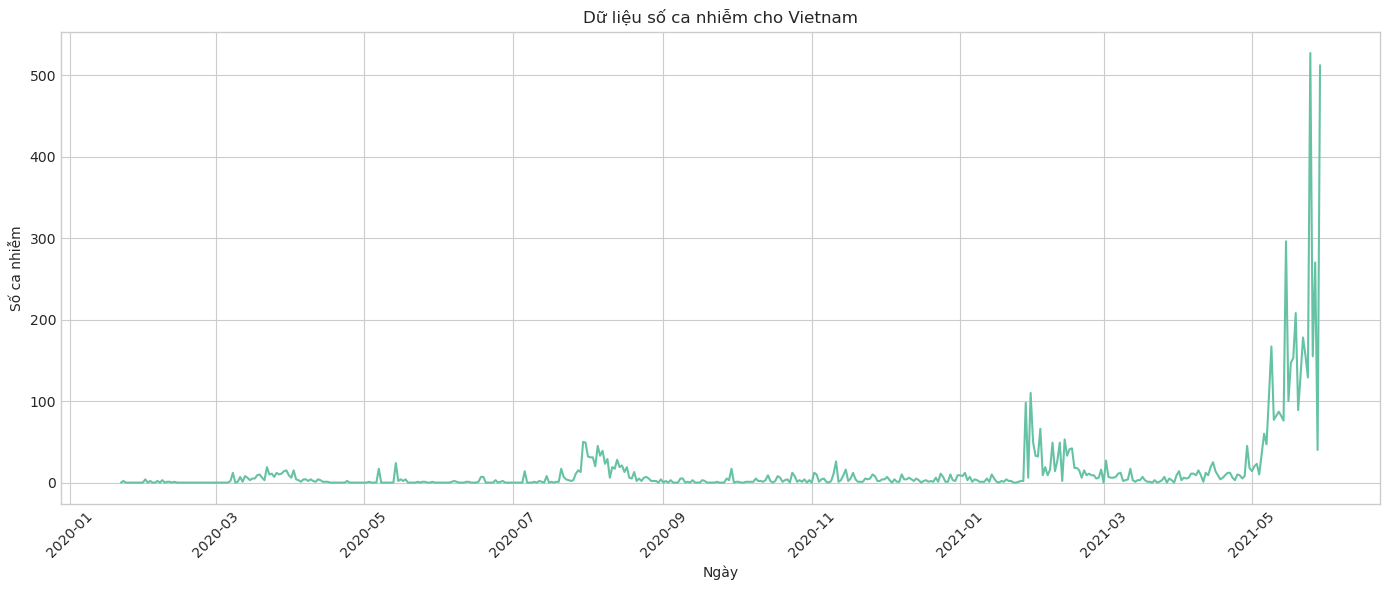

In [2]:
print(f"\n{'='*80}")
print(f"  HUẤN LUYỆN MÔ HÌNH CHO CONFIRMED - {country}")
print(f"{'='*80}")

confirmed_model = ProphetLSTMEnsemble(
    ensemble_method='weighted_average',
    prophet_weight=prophet_weight,
    lstm_weight=lstm_weight,
    stacking=stacking
)

confirmed_data = confirmed_model.load_and_prepare_data(CONFIRMED_FILE, country, "Confirmed")
confirmed_train, confirmed_test = confirmed_model.split_train_test(confirmed_data, test_size)

print(f"Dữ liệu Confirmed cho {country}:")
print(f"- Tổng số ngày: {len(confirmed_data)}")
print(f"- Thời gian: từ {confirmed_data['Date'].min().date()} đến {confirmed_data['Date'].max().date()}")
print(f"- Tập train: {len(confirmed_train)} ngày")
print(f"- Tập test: {len(confirmed_test)} ngày")

plt.figure(figsize=(14, 6))
plt.plot(confirmed_data['Date'], confirmed_data["Confirmed"])
plt.title(f'Dữ liệu số ca nhiễm cho {country}')
plt.xlabel('Ngày')
plt.ylabel('Số ca nhiễm')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [3]:
confirmed_model_exists = confirmed_model.check_model_exists(country, "Confirmed")

if confirmed_model_exists and not force_retrain:
    print(f"Mô hình cho {country} - Confirmed đã tồn tại. Đang tải mô hình...")
    confirmed_model.load_models(country, "Confirmed")
    print("Đã tải mô hình thành công!")
else:
    if confirmed_model_exists and force_retrain:
        print(f"Bắt buộc huấn luyện lại mô hình Confirmed...")
    else:
        print(f"Huấn luyện mô hình mới cho Confirmed...")
    
    confirmed_prophet_data = confirmed_model.prepare_prophet_data(confirmed_train, "Confirmed")
    
    print("Đang huấn luyện mô hình Prophet...")
    confirmed_prophet_forecast = confirmed_model.fit_prophet(confirmed_prophet_data, test_size, future_periods)
    
    confirmed_prophet_train_pred = confirmed_prophet_forecast.iloc[:len(confirmed_train)]['yhat'].values
    
    print("Đang chuẩn bị dữ liệu cho LSTM...")
    if stacking:
        confirmed_X_train, confirmed_y_train, _ = confirmed_model.prepare_stacking_data(
            confirmed_prophet_train_pred, 
            confirmed_train["Confirmed"].values, 
            confirmed_model.look_back
        )
    else:
        confirmed_X_train, confirmed_y_train, _ = confirmed_model.prepare_lstm_data(
            confirmed_train["Confirmed"].values,
            confirmed_model.look_back
        )
    
    print(f"Đang huấn luyện LSTM với {lstm_epochs} epochs...")
    confirmed_history = confirmed_model.fit_lstm(confirmed_X_train, confirmed_y_train, epochs=lstm_epochs)
    
    if save_model:
        print("Đang lưu mô hình...")
        confirmed_model_dir = confirmed_model.save_models(country, "Confirmed")
        print(f"Đã lưu mô hình vào: {confirmed_model_dir}")

Mô hình cho Vietnam - Confirmed đã tồn tại. Đang tải mô hình...
Đã tải mô hình thành công từ thư mục: models/Vietnam_Confirmed
Đã tải mô hình thành công!


In [4]:
print("\nĐánh giá mô hình trên tập test:")

confirmed_prophet_test_pred = confirmed_model.prophet_forecast.iloc[-test_size-future_periods:-future_periods]['yhat'].values

if confirmed_model.stacking:
    confirmed_prophet_train_pred = confirmed_model.prophet_forecast.iloc[:len(confirmed_train)]['yhat'].values
    
    confirmed_train_combined = np.column_stack([
        confirmed_train["Confirmed"].values, 
        confirmed_prophet_train_pred
    ])
    
    confirmed_train_scaled = confirmed_model.scaler.transform(confirmed_train_combined)
    
    confirmed_X_train = []
    confirmed_y_train = []
    look_back = confirmed_model.look_back
    
    for i in range(len(confirmed_train_scaled) - look_back):
        confirmed_X_train.append(confirmed_train_scaled[i:i+look_back])
        confirmed_y_train.append(confirmed_train_scaled[i+look_back, 0])
    
    confirmed_X_train = np.array(confirmed_X_train)
    confirmed_y_train = np.array(confirmed_y_train)
    
    confirmed_lstm_test_pred = []
    confirmed_last_sequence = confirmed_X_train[-1].reshape(1, look_back, 2)
    
    for _ in range(test_size):
        next_pred = confirmed_model.lstm_model.predict(confirmed_last_sequence)
        confirmed_lstm_test_pred.append(next_pred[0, 0])
        
        confirmed_last_sequence = np.roll(confirmed_last_sequence, -1, axis=1)
        confirmed_last_sequence[0, -1, 0] = next_pred
        confirmed_last_sequence[0, -1, 1] = confirmed_prophet_test_pred[len(confirmed_lstm_test_pred)-1]
    
    confirmed_lstm_test_pred = confirmed_model.scaler.inverse_transform(
        np.column_stack([
            np.array(confirmed_lstm_test_pred), 
            confirmed_prophet_test_pred[:len(confirmed_lstm_test_pred)]
        ])
    )[:, 0]

else:
    confirmed_X_train, confirmed_y_train, confirmed_scaled_train = confirmed_model.prepare_lstm_data(
        confirmed_train["Confirmed"].values,
        confirmed_model.look_back
    )
    
    confirmed_lstm_test_pred = []
    confirmed_last_sequence = confirmed_scaled_train[-confirmed_model.look_back:].reshape(1, confirmed_model.look_back, 1)
    
    for _ in range(test_size):
        next_pred = confirmed_model.lstm_model.predict(confirmed_last_sequence)
        confirmed_lstm_test_pred.append(next_pred[0, 0])
        confirmed_last_sequence = np.roll(confirmed_last_sequence, -1, axis=1)
        confirmed_last_sequence[0, -1, 0] = next_pred
    
    confirmed_lstm_test_pred = confirmed_model.scaler.inverse_transform(
        np.array(confirmed_lstm_test_pred).reshape(-1, 1)
    ).flatten()

confirmed_ensemble_test_pred = (
    prophet_weight * confirmed_prophet_test_pred +
    lstm_weight * confirmed_lstm_test_pred
)

confirmed_metrics = confirmed_model.evaluate(
    confirmed_test, 
    "Confirmed", 
    confirmed_prophet_test_pred, 
    confirmed_lstm_test_pred, 
    confirmed_ensemble_test_pred
)

for model_name, model_metrics in confirmed_metrics.items():
    print(f"{model_name}:")
    for metric_name, metric_value in model_metrics.items():
        print(f"  {metric_name}: {metric_value:.2f}")


Đánh giá mô hình trên tập test:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━


Dự đoán 60 ngày trong tương lai:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━

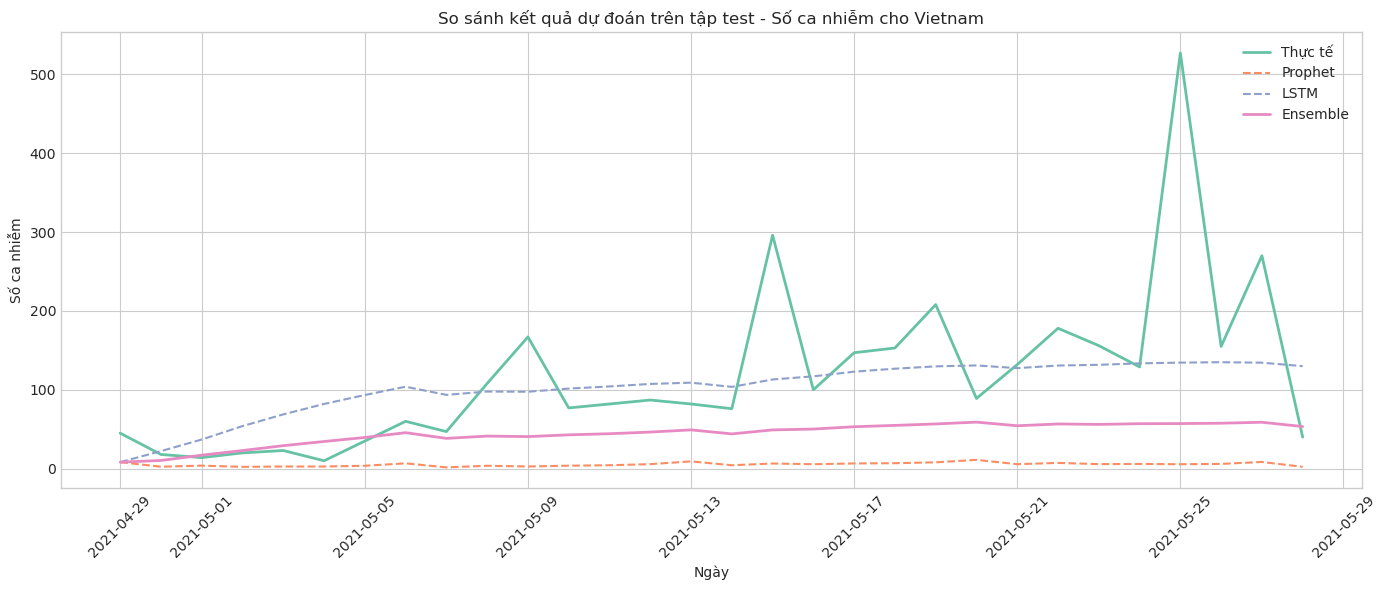

In [6]:
print(f"\nDự đoán {future_periods} ngày trong tương lai:")
confirmed_future = confirmed_model.predict(confirmed_data, "Confirmed", future_periods)

# Ensure consistent length
min_length = min(
    len(confirmed_test['Date'].values),
    len(confirmed_test["Confirmed"].values),
    len(confirmed_prophet_test_pred),
    len(confirmed_lstm_test_pred),
    len(confirmed_ensemble_test_pred)
)

confirmed_test_predictions = pd.DataFrame({
    'Date': confirmed_test['Date'].values[:min_length],
    'Actual': confirmed_test["Confirmed"].values[:min_length],
    'Prophet': confirmed_prophet_test_pred[:min_length],
    'LSTM': confirmed_lstm_test_pred[:min_length],
    'Ensemble': confirmed_ensemble_test_pred[:min_length]
})

# Debug print to check lengths
print("Lengths:")
print("Date:", len(confirmed_test_predictions['Date']))
print("Actual:", len(confirmed_test_predictions['Actual']))
print("Prophet:", len(confirmed_test_predictions['Prophet']))
print("LSTM:", len(confirmed_test_predictions['LSTM']))
print("Ensemble:", len(confirmed_test_predictions['Ensemble']))

plt.figure(figsize=(14, 6))
plt.plot(confirmed_test_predictions['Date'], confirmed_test_predictions['Actual'], label='Thực tế', linewidth=2)
plt.plot(confirmed_test_predictions['Date'], confirmed_test_predictions['Prophet'], label='Prophet', linestyle='--')
plt.plot(confirmed_test_predictions['Date'], confirmed_test_predictions['LSTM'], label='LSTM', linestyle='--')
plt.plot(confirmed_test_predictions['Date'], confirmed_test_predictions['Ensemble'], label='Ensemble', linewidth=2)

plt.title(f'So sánh kết quả dự đoán trên tập test - Số ca nhiễm cho {country}')
plt.xlabel('Ngày')
plt.ylabel('Số ca nhiễm')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

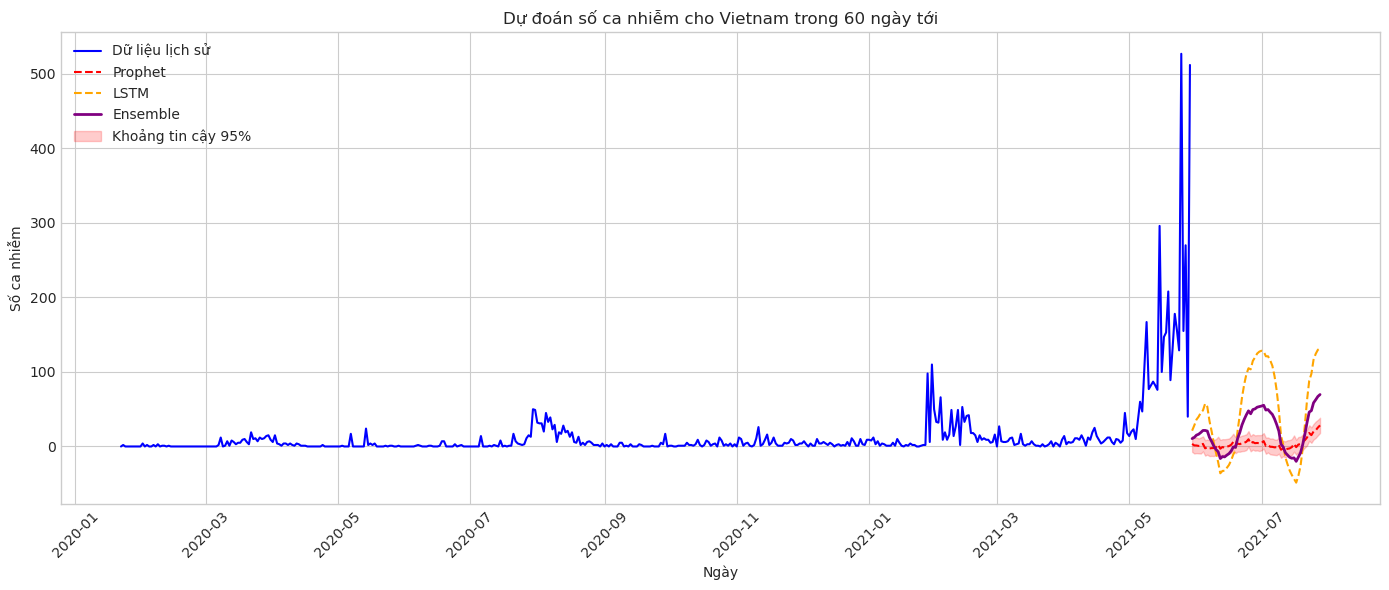

In [7]:
plt.figure(figsize=(14, 6))
plt.plot(confirmed_data['Date'], confirmed_data["Confirmed"], label='Dữ liệu lịch sử', color='blue')
plt.plot(confirmed_future['Date'], confirmed_future['Prophet_Prediction'], label='Prophet', linestyle='--', color='red')
plt.plot(confirmed_future['Date'], confirmed_future['LSTM_Prediction'], label='LSTM', linestyle='--', color='orange')
plt.plot(confirmed_future['Date'], confirmed_future['Ensemble_Prediction'], label='Ensemble', linewidth=2, color='purple')

plt.fill_between(
    confirmed_future['Date'],
    confirmed_future['Lower_CI'],
    confirmed_future['Upper_CI'],
    alpha=0.2, color='red', label='Khoảng tin cậy 95%'
)

plt.title(f'Dự đoán số ca nhiễm cho {country} trong {future_periods} ngày tới')
plt.xlabel('Ngày')
plt.ylabel('Số ca nhiễm')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
confirmed_file = f"results/{country}_Confirmed_forecast_{timestamp}.csv"
confirmed_future.to_csv(confirmed_file, index=False)
print(f"Đã lưu kết quả dự đoán vào file: {confirmed_file}")

Đã lưu kết quả dự đoán vào file: results/Vietnam_Confirmed_forecast_20250331_204454.csv


In [9]:
confirmed_display = confirmed_future.copy()
confirmed_display['Date'] = confirmed_display['Date'].dt.strftime('%Y-%m-%d')
confirmed_display = confirmed_display.round(2)
print("\nDự đoán 5 ngày đầu tiên:")
print(confirmed_display.head(5))


Dự đoán 5 ngày đầu tiên:
         Date  Prophet_Prediction  LSTM_Prediction  Ensemble_Prediction  \
0  2021-05-30                3.43            21.24                10.55   
1  2021-05-31                1.41            28.28                12.16   
2  2021-06-01                1.32            36.04                15.21   
3  2021-06-02                0.72            39.99                16.43   
4  2021-06-03                1.02            45.35                18.75   

   Lower_CI  Upper_CI  
0     -7.24     14.07  
1     -9.43     11.75  
2     -8.91     12.00  
3     -9.21     10.75  
4     -9.51     12.02  



  HUẤN LUYỆN MÔ HÌNH CHO DEATHS - Vietnam
Dữ liệu Deaths cho Vietnam:
- Tổng số ngày: 494
- Thời gian: từ 2020-01-22 đến 2021-05-29
- Tập train: 463 ngày
- Tập test: 31 ngày


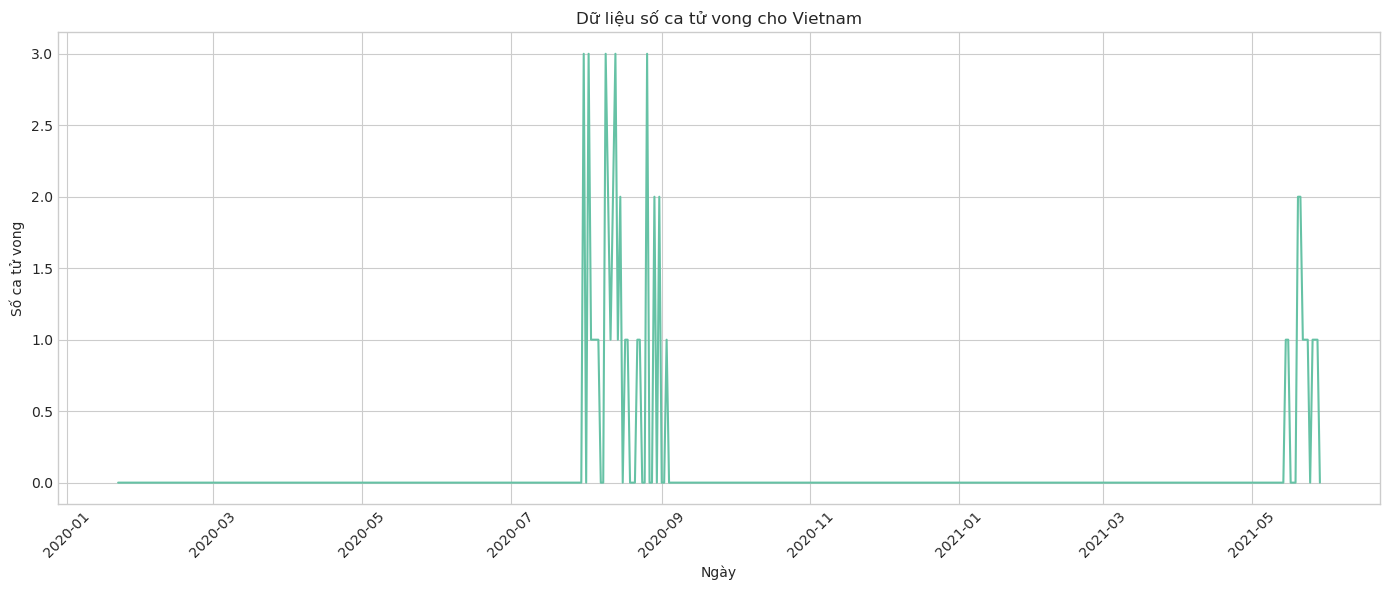

In [10]:
print(f"\n{'='*80}")
print(f"  HUẤN LUYỆN MÔ HÌNH CHO DEATHS - {country}")
print(f"{'='*80}")

deaths_model = ProphetLSTMEnsemble(
    ensemble_method='weighted_average',
    prophet_weight=prophet_weight,
    lstm_weight=lstm_weight,
    stacking=stacking
)

deaths_data = deaths_model.load_and_prepare_data(DEATHS_FILE, country, "Deaths")
deaths_train, deaths_test = deaths_model.split_train_test(deaths_data, test_size)

print(f"Dữ liệu Deaths cho {country}:")
print(f"- Tổng số ngày: {len(deaths_data)}")
print(f"- Thời gian: từ {deaths_data['Date'].min().date()} đến {deaths_data['Date'].max().date()}")
print(f"- Tập train: {len(deaths_train)} ngày")
print(f"- Tập test: {len(deaths_test)} ngày")

plt.figure(figsize=(14, 6))
plt.plot(deaths_data['Date'], deaths_data["Deaths"])
plt.title(f'Dữ liệu số ca tử vong cho {country}')
plt.xlabel('Ngày')
plt.ylabel('Số ca tử vong')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
deaths_model_exists = deaths_model.check_model_exists(country, "Deaths")

if deaths_model_exists and not force_retrain:
    print(f"Mô hình cho {country} - Deaths đã tồn tại. Đang tải mô hình...")
    deaths_model.load_models(country, "Deaths")
    print("Đã tải mô hình thành công!")
else:
    if deaths_model_exists and force_retrain:
        print(f"Bắt buộc huấn luyện lại mô hình Deaths...")
    else:
        print(f"Huấn luyện mô hình mới cho Deaths...")
    
    deaths_prophet_data = deaths_model.prepare_prophet_data(deaths_train, "Deaths")
    
    print("Đang huấn luyện mô hình Prophet...")
    deaths_prophet_forecast = deaths_model.fit_prophet(deaths_prophet_data, test_size, future_periods)
    
    deaths_prophet_train_pred = deaths_prophet_forecast.iloc[:len(deaths_train)]['yhat'].values
    
    print("Đang chuẩn bị dữ liệu cho LSTM...")
    if stacking:
        deaths_X_train, deaths_y_train, _ = deaths_model.prepare_stacking_data(
            deaths_prophet_train_pred, 
            deaths_train["Deaths"].values, 
            deaths_model.look_back
        )
    else:
        deaths_X_train, deaths_y_train, _ = deaths_model.prepare_lstm_data(
            deaths_train["Deaths"].values,
            deaths_model.look_back
        )
    
    print(f"Đang huấn luyện LSTM với {lstm_epochs} epochs...")
    deaths_history = deaths_model.fit_lstm(deaths_X_train, deaths_y_train, epochs=lstm_epochs)
    
    if save_model:
        print("Đang lưu mô hình...")
        deaths_model_dir = deaths_model.save_models(country, "Deaths")
        print(f"Đã lưu mô hình vào: {deaths_model_dir}")

20:45:19 - cmdstanpy - INFO - Chain [1] start processing
20:45:19 - cmdstanpy - INFO - Chain [1] done processing


Huấn luyện mô hình mới cho Deaths...
Đang huấn luyện mô hình Prophet...
Đang huấn luyện mô hình Prophet...
Đang chuẩn bị dữ liệu cho LSTM...
Đang huấn luyện LSTM với 50 epochs...
Đang huấn luyện mô hình LSTM...
Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0185 - val_loss: 1.4181e-05
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0137 - val_loss: 3.0018e-05
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0136 - val_loss: 1.7784e-04
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0137 - val_loss: 2.1906e-05
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0123 - val_loss: 1.3191e-04
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0120 - val_loss: 2.7325e-05
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0129 - val_loss: 8.9417e-05
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0128 - val_loss: 9.5517e-05
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0123 - val_loss:

In [13]:
print("\nĐánh giá mô hình trên tập test:")

deaths_prophet_test_pred = deaths_model.prophet_forecast.iloc[-test_size-future_periods:-future_periods]['yhat'].values[:test_size]

if deaths_model.stacking:
    deaths_prophet_train_pred = deaths_model.prophet_forecast.iloc[:len(deaths_train)]['yhat'].values
    
    deaths_last_sequence = np.column_stack([
        deaths_train["Deaths"].values[-deaths_model.look_back:],
        deaths_prophet_train_pred[-deaths_model.look_back:]
    ])
    
    deaths_current_input = deaths_model.scaler.transform(deaths_last_sequence).reshape(1, deaths_model.look_back, 2)
    
    deaths_lstm_test_pred = []
    
    for _ in range(test_size):
        next_pred = deaths_model.lstm_model.predict(deaths_current_input)
        deaths_lstm_test_pred.append(next_pred[0, 0])
        
        deaths_current_input = np.roll(deaths_current_input, -1, axis=1)
        deaths_current_input[0, -1, 0] = next_pred
        
        if len(deaths_lstm_test_pred) <= len(deaths_prophet_test_pred):
            deaths_current_input[0, -1, 1] = deaths_prophet_test_pred[len(deaths_lstm_test_pred)-1]
        else:
            deaths_current_input[0, -1, 1] = next_pred
    
    deaths_lstm_test_pred = deaths_model.scaler.inverse_transform(
        np.column_stack([
            np.array(deaths_lstm_test_pred), 
            deaths_prophet_test_pred[:len(deaths_lstm_test_pred)]
        ])
    )[:, 0]

else:
    deaths_X_train, deaths_y_train, deaths_scaled_train = deaths_model.prepare_lstm_data(
        deaths_train["Deaths"].values,
        deaths_model.look_back
    )
    
    deaths_lstm_test_pred = []
    deaths_last_sequence = deaths_scaled_train[-deaths_model.look_back:].reshape(1, deaths_model.look_back, 1)
    
    for _ in range(test_size):
        next_pred = deaths_model.lstm_model.predict(deaths_last_sequence)
        deaths_lstm_test_pred.append(next_pred[0, 0])
        deaths_last_sequence = np.roll(deaths_last_sequence, -1, axis=1)
        deaths_last_sequence[0, -1, 0] = next_pred
    
    deaths_lstm_test_pred = deaths_model.scaler.inverse_transform(
        np.array(deaths_lstm_test_pred).reshape(-1, 1)
    ).flatten()

min_length = min(len(deaths_prophet_test_pred), len(deaths_lstm_test_pred))

deaths_prophet_test_pred = deaths_prophet_test_pred[:min_length]
deaths_lstm_test_pred = deaths_lstm_test_pred[:min_length]

deaths_ensemble_test_pred = (
    prophet_weight * deaths_prophet_test_pred +
    lstm_weight * deaths_lstm_test_pred
)

deaths_metrics = deaths_model.evaluate(
    deaths_test.iloc[:min_length], 
    "Deaths", 
    deaths_prophet_test_pred, 
    deaths_lstm_test_pred, 
    deaths_ensemble_test_pred
)

for model_name, model_metrics in deaths_metrics.items():
    print(f"{model_name}:")
    for metric_name, metric_value in model_metrics.items():
        print(f"  {metric_name}: {metric_value:.2f}")

print(f"\nDự đoán {future_periods} ngày trong tương lai:")
deaths_future = deaths_model.predict(deaths_data, "Deaths", future_periods)


Đánh giá mô hình trên tập test:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━

Lengths of arrays:
Date: 30
Actual: 30
Prophet: 30
LSTM: 30
Ensemble: 30


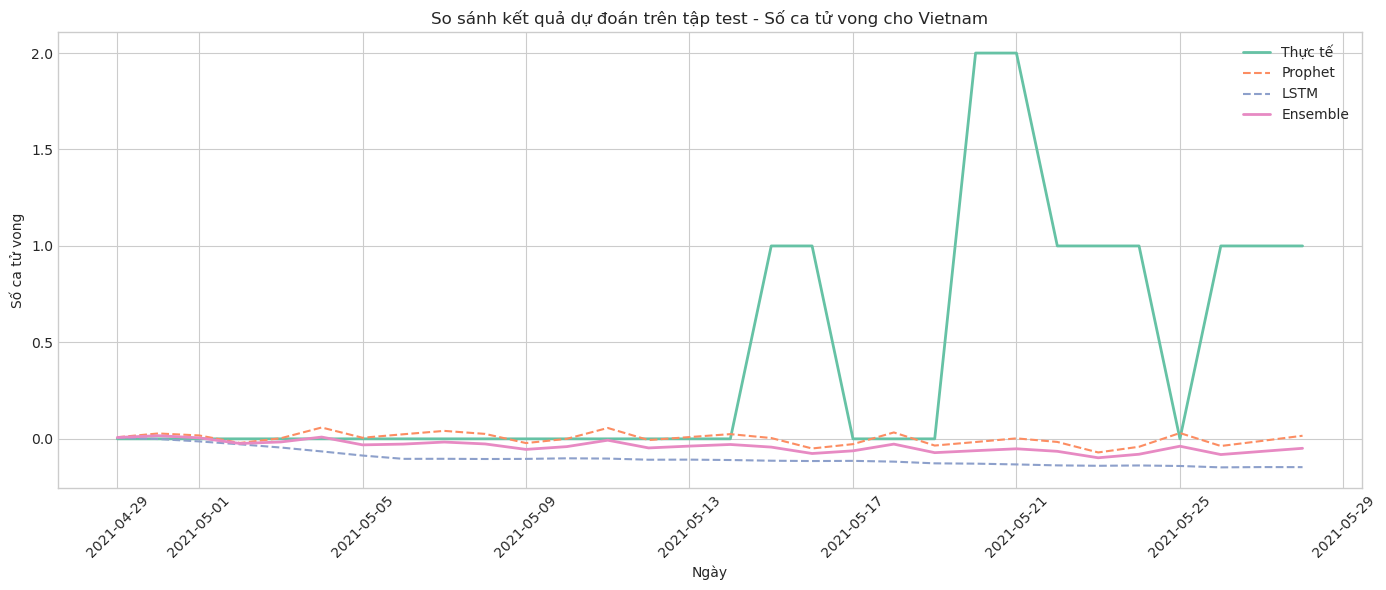

In [15]:
min_length = min(
    len(deaths_test['Date'].values),
    len(deaths_test["Deaths"].values),
    len(deaths_prophet_test_pred),
    len(deaths_lstm_test_pred),
    len(deaths_ensemble_test_pred)
)

deaths_test_predictions = pd.DataFrame({
    'Date': deaths_test['Date'].values[:min_length],
    'Actual': deaths_test["Deaths"].values[:min_length],
    'Prophet': deaths_prophet_test_pred[:min_length],
    'LSTM': deaths_lstm_test_pred[:min_length],
    'Ensemble': deaths_ensemble_test_pred[:min_length]
})

print("Lengths of arrays:")
print("Date:", len(deaths_test_predictions['Date']))
print("Actual:", len(deaths_test_predictions['Actual']))
print("Prophet:", len(deaths_test_predictions['Prophet']))
print("LSTM:", len(deaths_test_predictions['LSTM']))
print("Ensemble:", len(deaths_test_predictions['Ensemble']))

plt.figure(figsize=(14, 6))
plt.plot(deaths_test_predictions['Date'], deaths_test_predictions['Actual'], label='Thực tế', linewidth=2)
plt.plot(deaths_test_predictions['Date'], deaths_test_predictions['Prophet'], label='Prophet', linestyle='--')
plt.plot(deaths_test_predictions['Date'], deaths_test_predictions['LSTM'], label='LSTM', linestyle='--')
plt.plot(deaths_test_predictions['Date'], deaths_test_predictions['Ensemble'], label='Ensemble', linewidth=2)

plt.title(f'So sánh kết quả dự đoán trên tập test - Số ca tử vong cho {country}')
plt.xlabel('Ngày')
plt.ylabel('Số ca tử vong')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

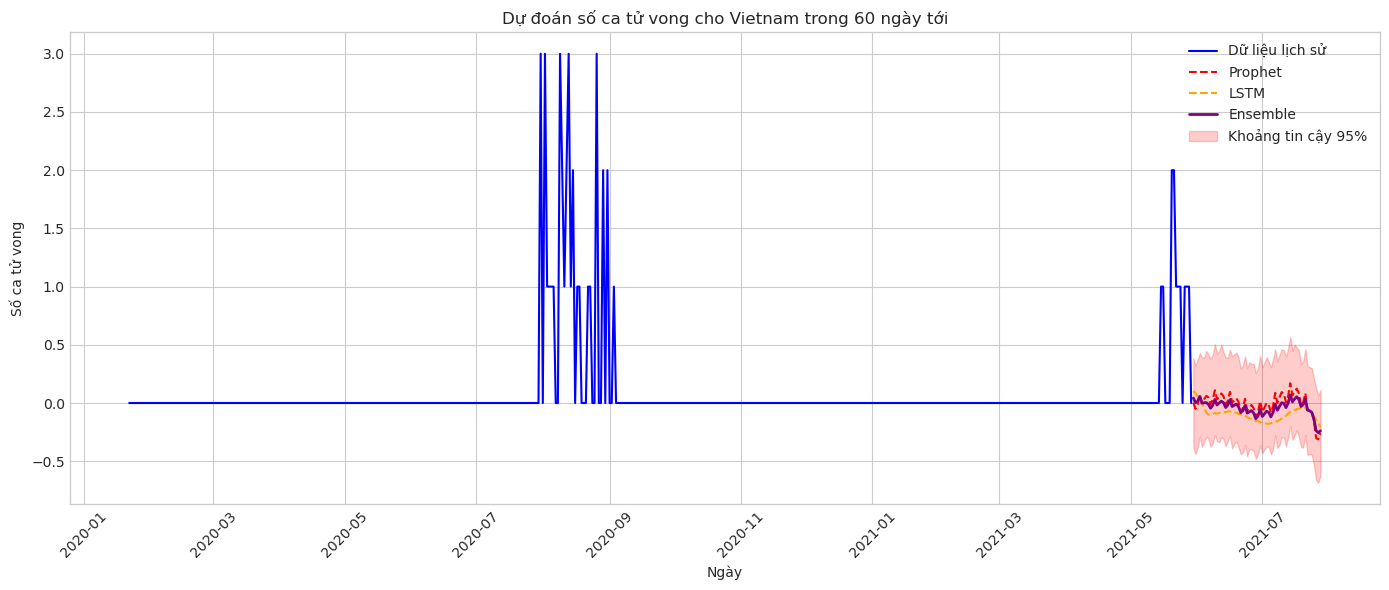

In [16]:
plt.figure(figsize=(14, 6))
plt.plot(deaths_data['Date'], deaths_data["Deaths"], label='Dữ liệu lịch sử', color='blue')
plt.plot(deaths_future['Date'], deaths_future['Prophet_Prediction'], label='Prophet', linestyle='--', color='red')
plt.plot(deaths_future['Date'], deaths_future['LSTM_Prediction'], label='LSTM', linestyle='--', color='orange')
plt.plot(deaths_future['Date'], deaths_future['Ensemble_Prediction'], label='Ensemble', linewidth=2, color='purple')

plt.fill_between(
    deaths_future['Date'],
    deaths_future['Lower_CI'],
    deaths_future['Upper_CI'],
    alpha=0.2, color='red', label='Khoảng tin cậy 95%'
)

plt.title(f'Dự đoán số ca tử vong cho {country} trong {future_periods} ngày tới')
plt.xlabel('Ngày')
plt.ylabel('Số ca tử vong')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
deaths_file = f"results/{country}_Deaths_forecast_{timestamp}.csv"
deaths_future.to_csv(deaths_file, index=False)
print(f"Đã lưu kết quả dự đoán vào file: {deaths_file}")

deaths_display = deaths_future.copy()
deaths_display['Date'] = deaths_display['Date'].dt.strftime('%Y-%m-%d')
deaths_display = deaths_display.round(2)
print("\nDự đoán 5 ngày đầu tiên:")
print(deaths_display.head(5))

Đã lưu kết quả dự đoán vào file: results/Vietnam_Deaths_forecast_20250331_204832.csv

Dự đoán 5 ngày đầu tiên:
         Date  Prophet_Prediction  LSTM_Prediction  Ensemble_Prediction  \
0  2021-05-30                0.00             0.10                 0.04   
1  2021-05-31               -0.05             0.08                 0.00   
2  2021-06-01               -0.01             0.06                 0.02   
3  2021-06-02                0.07             0.04                 0.06   
4  2021-06-03                0.00            -0.00                -0.00   

   Lower_CI  Upper_CI  
0     -0.38      0.39  
1     -0.44      0.32  
2     -0.38      0.37  
3     -0.29      0.43  
4     -0.38      0.39  



  HUẤN LUYỆN MÔ HÌNH CHO RECOVERED - Vietnam
Dữ liệu Recovered cho Vietnam:
- Tổng số ngày: 494
- Thời gian: từ 2020-01-22 đến 2021-05-29
- Tập train: 463 ngày
- Tập test: 31 ngày


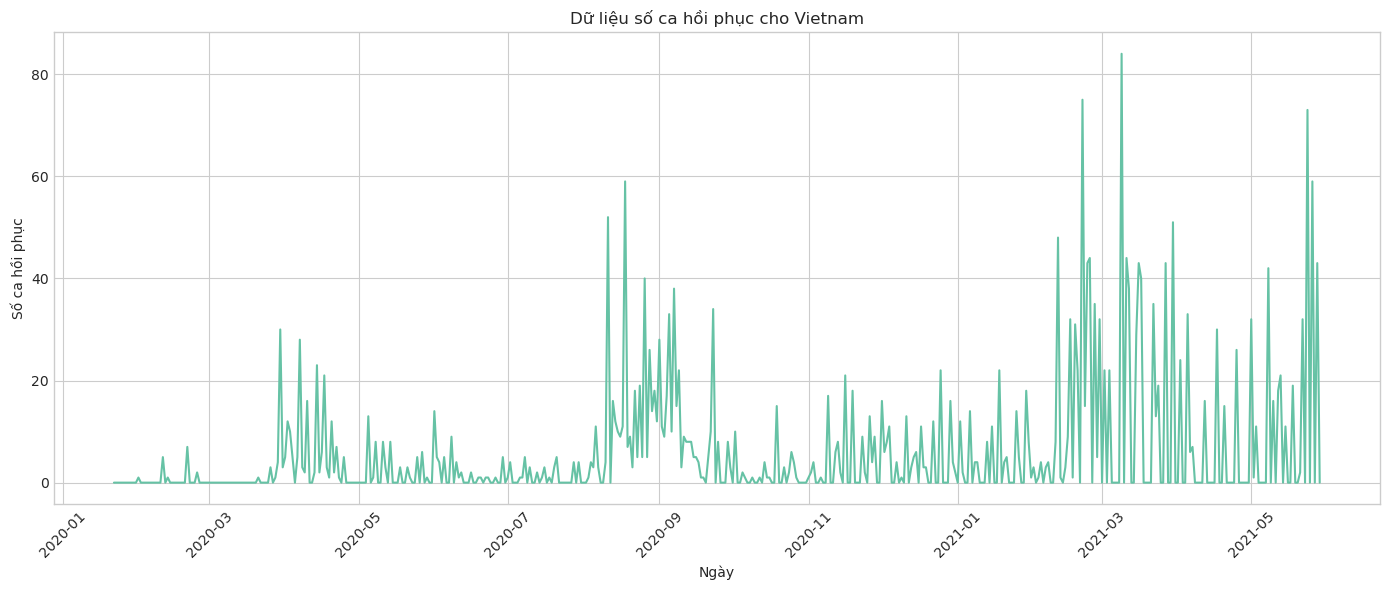

20:49:00 - cmdstanpy - INFO - Chain [1] start processing
20:49:01 - cmdstanpy - INFO - Chain [1] done processing


Huấn luyện mô hình mới cho Recovered...
Đang huấn luyện mô hình Prophet...
Đang huấn luyện mô hình Prophet...
Đang chuẩn bị dữ liệu cho LSTM...
Đang huấn luyện LSTM với 50 epochs...
Đang huấn luyện mô hình LSTM...
Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.0085 - val_loss: 0.0422
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0065 - val_loss: 0.0413
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0060 - val_loss: 0.0414
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0064 - val_loss: 0.0414
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0062 - val_loss: 0.0415
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0060 - val_loss: 0.0415
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0061 - val_loss: 0.0415
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0063 - val_loss: 0.0416
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0066 - val_loss: 0.0416
Epoch 10/50
12/12 ━━━

In [18]:
print(f"\n{'='*80}")
print(f"  HUẤN LUYỆN MÔ HÌNH CHO RECOVERED - {country}")
print(f"{'='*80}")

recovered_model = ProphetLSTMEnsemble(
    ensemble_method='weighted_average',
    prophet_weight=prophet_weight,
    lstm_weight=lstm_weight,
    stacking=stacking
)

recovered_data = recovered_model.load_and_prepare_data(RECOVERED_FILE, country, "Recovered")
recovered_train, recovered_test = recovered_model.split_train_test(recovered_data, test_size)

print(f"Dữ liệu Recovered cho {country}:")
print(f"- Tổng số ngày: {len(recovered_data)}")
print(f"- Thời gian: từ {recovered_data['Date'].min().date()} đến {recovered_data['Date'].max().date()}")
print(f"- Tập train: {len(recovered_train)} ngày")
print(f"- Tập test: {len(recovered_test)} ngày")

plt.figure(figsize=(14, 6))
plt.plot(recovered_data['Date'], recovered_data["Recovered"])
plt.title(f'Dữ liệu số ca hồi phục cho {country}')
plt.xlabel('Ngày')
plt.ylabel('Số ca hồi phục')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

recovered_model_exists = recovered_model.check_model_exists(country, "Recovered")

if recovered_model_exists and not force_retrain:
    print(f"Mô hình cho {country} - Recovered đã tồn tại. Đang tải mô hình...")
    recovered_model.load_models(country, "Recovered")
    print("Đã tải mô hình thành công!")
else:
    if recovered_model_exists and force_retrain:
        print(f"Bắt buộc huấn luyện lại mô hình Recovered...")
    else:
        print(f"Huấn luyện mô hình mới cho Recovered...")
    
    recovered_prophet_data = recovered_model.prepare_prophet_data(recovered_train, "Recovered")
    
    print("Đang huấn luyện mô hình Prophet...")
    recovered_prophet_forecast = recovered_model.fit_prophet(recovered_prophet_data, test_size, future_periods)
    
    recovered_prophet_train_pred = recovered_prophet_forecast.iloc[:len(recovered_train)]['yhat'].values
    
    print("Đang chuẩn bị dữ liệu cho LSTM...")
    if stacking:
        recovered_X_train, recovered_y_train, _ = recovered_model.prepare_stacking_data(
            recovered_prophet_train_pred, 
            recovered_train["Recovered"].values, 
            recovered_model.look_back
        )
    else:
        recovered_X_train, recovered_y_train, _ = recovered_model.prepare_lstm_data(
            recovered_train["Recovered"].values,
            recovered_model.look_back
        )
    
    print(f"Đang huấn luyện LSTM với {lstm_epochs} epochs...")
    recovered_history = recovered_model.fit_lstm(recovered_X_train, recovered_y_train, epochs=lstm_epochs)
    
    if save_model:
        print("Đang lưu mô hình...")
        recovered_model_dir = recovered_model.save_models(country, "Recovered")
        print(f"Đã lưu mô hình vào: {recovered_model_dir}")

In [20]:
print("\nĐánh giá mô hình trên tập test:")

recovered_prophet_test_pred = recovered_model.prophet_forecast.iloc[-test_size-future_periods:-future_periods]['yhat'].values

if recovered_model.stacking:
    recovered_prophet_train_pred = recovered_model.prophet_forecast.iloc[:len(recovered_train)]['yhat'].values
    
    recovered_last_sequence = np.column_stack([
        recovered_train["Recovered"].values[-recovered_model.look_back:],
        recovered_prophet_train_pred[-recovered_model.look_back:]
    ])
    
    recovered_current_input = recovered_model.scaler.transform(recovered_last_sequence).reshape(1, recovered_model.look_back, 2)
    
    recovered_lstm_test_pred = []
    
    for _ in range(test_size):
        next_pred = recovered_model.lstm_model.predict(recovered_current_input)
        recovered_lstm_test_pred.append(next_pred[0, 0])
        
        recovered_current_input = np.roll(recovered_current_input, -1, axis=1)
        recovered_current_input[0, -1, 0] = next_pred
        
        if len(recovered_lstm_test_pred) <= len(recovered_prophet_test_pred):
            recovered_current_input[0, -1, 1] = recovered_prophet_test_pred[len(recovered_lstm_test_pred)-1]
        else:
            recovered_current_input[0, -1, 1] = next_pred
    
    recovered_lstm_test_pred = recovered_model.scaler.inverse_transform(
        np.column_stack([
            np.array(recovered_lstm_test_pred), 
            recovered_prophet_test_pred[:len(recovered_lstm_test_pred)]
        ])
    )[:, 0]

else:
    recovered_X_train, recovered_y_train, recovered_scaled_train = recovered_model.prepare_lstm_data(
        recovered_train["Recovered"].values,
        recovered_model.look_back
    )
    
    recovered_lstm_test_pred = []
    recovered_last_sequence = recovered_scaled_train[-recovered_model.look_back:].reshape(1, recovered_model.look_back, 1)
    
    for _ in range(test_size):
        next_pred = recovered_model.lstm_model.predict(recovered_last_sequence)
        recovered_lstm_test_pred.append(next_pred[0, 0])
        recovered_last_sequence = np.roll(recovered_last_sequence, -1, axis=1)
        recovered_last_sequence[0, -1, 0] = next_pred
    
    recovered_lstm_test_pred = recovered_model.scaler.inverse_transform(
        np.array(recovered_lstm_test_pred).reshape(-1, 1)
    ).flatten()

min_length = min(len(recovered_prophet_test_pred), len(recovered_lstm_test_pred))

recovered_prophet_test_pred = recovered_prophet_test_pred[:min_length]
recovered_lstm_test_pred = recovered_lstm_test_pred[:min_length]

recovered_ensemble_test_pred = (
    prophet_weight * recovered_prophet_test_pred +
    lstm_weight * recovered_lstm_test_pred
)

recovered_metrics = recovered_model.evaluate(
    recovered_test.iloc[:min_length], 
    "Recovered", 
    recovered_prophet_test_pred, 
    recovered_lstm_test_pred, 
    recovered_ensemble_test_pred
)

for model_name, model_metrics in recovered_metrics.items():
    print(f"{model_name}:")
    for metric_name, metric_value in model_metrics.items():
        print(f"  {metric_name}: {metric_value:.2f}")


Đánh giá mô hình trên tập test:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━


Dự đoán 60 ngày trong tương lai:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━

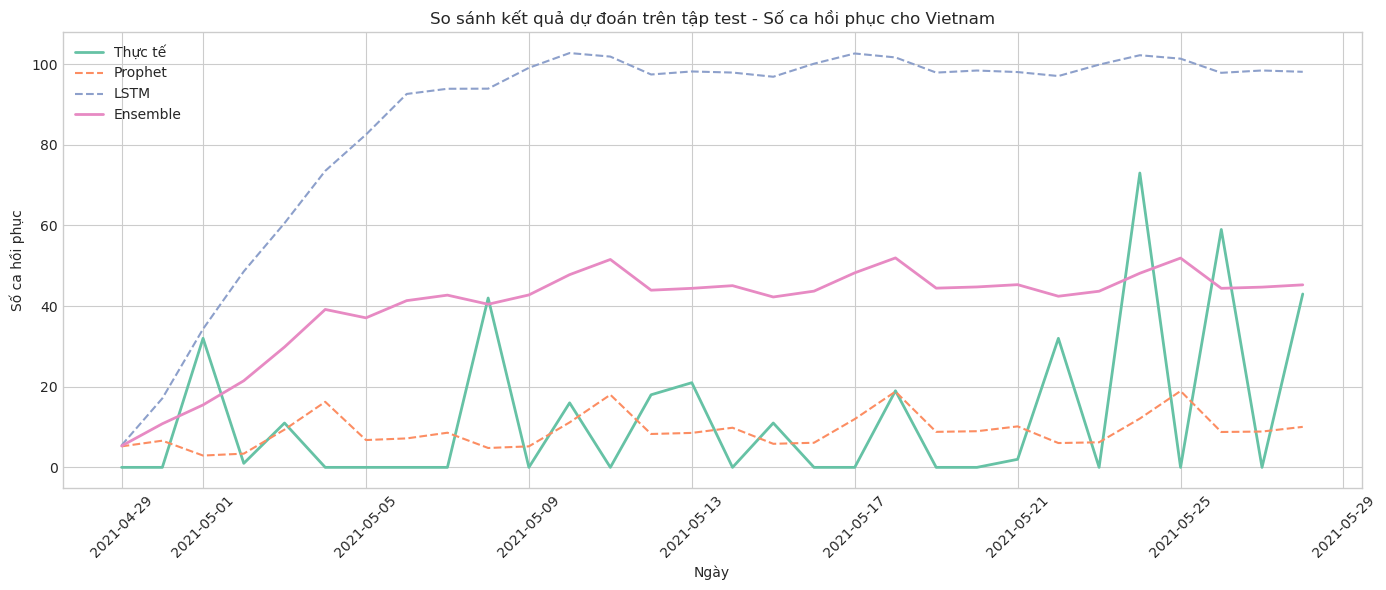

In [22]:
print(f"\nDự đoán {future_periods} ngày trong tương lai:")
recovered_future = recovered_model.predict(recovered_data, "Recovered", future_periods)

min_length = min(
    len(recovered_test['Date'].values),
    len(recovered_test["Recovered"].values),
    len(recovered_prophet_test_pred),
    len(recovered_lstm_test_pred),
    len(recovered_ensemble_test_pred)
)

recovered_test_predictions = pd.DataFrame({
    'Date': recovered_test['Date'].values[:min_length],
    'Actual': recovered_test["Recovered"].values[:min_length],
    'Prophet': recovered_prophet_test_pred[:min_length],
    'LSTM': recovered_lstm_test_pred[:min_length],
    'Ensemble': recovered_ensemble_test_pred[:min_length]
})

print("Lengths of arrays:")
print("Date:", len(recovered_test_predictions['Date']))
print("Actual:", len(recovered_test_predictions['Actual']))
print("Prophet:", len(recovered_test_predictions['Prophet']))
print("LSTM:", len(recovered_test_predictions['LSTM']))
print("Ensemble:", len(recovered_test_predictions['Ensemble']))

plt.figure(figsize=(14, 6))
plt.plot(recovered_test_predictions['Date'], recovered_test_predictions['Actual'], label='Thực tế', linewidth=2)
plt.plot(recovered_test_predictions['Date'], recovered_test_predictions['Prophet'], label='Prophet', linestyle='--')
plt.plot(recovered_test_predictions['Date'], recovered_test_predictions['LSTM'], label='LSTM', linestyle='--')
plt.plot(recovered_test_predictions['Date'], recovered_test_predictions['Ensemble'], label='Ensemble', linewidth=2)

plt.title(f'So sánh kết quả dự đoán trên tập test - Số ca hồi phục cho {country}')
plt.xlabel('Ngày')
plt.ylabel('Số ca hồi phục')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

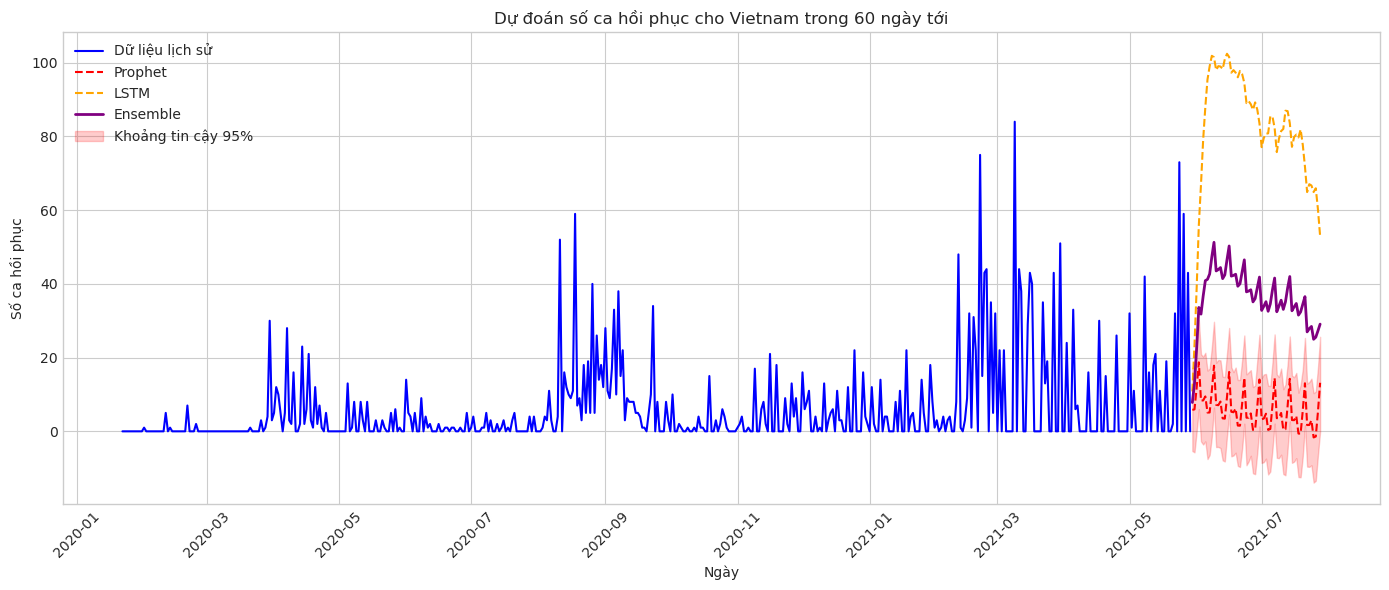

In [23]:
plt.figure(figsize=(14, 6))
plt.plot(recovered_data['Date'], recovered_data["Recovered"], label='Dữ liệu lịch sử', color='blue')
plt.plot(recovered_future['Date'], recovered_future['Prophet_Prediction'], label='Prophet', linestyle='--', color='red')
plt.plot(recovered_future['Date'], recovered_future['LSTM_Prediction'], label='LSTM', linestyle='--', color='orange')
plt.plot(recovered_future['Date'], recovered_future['Ensemble_Prediction'], label='Ensemble', linewidth=2, color='purple')

plt.fill_between(
    recovered_future['Date'],
    recovered_future['Lower_CI'],
    recovered_future['Upper_CI'],
    alpha=0.2, color='red', label='Khoảng tin cậy 95%'
)

plt.title(f'Dự đoán số ca hồi phục cho {country} trong {future_periods} ngày tới')
plt.xlabel('Ngày')
plt.ylabel('Số ca hồi phục')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [24]:

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
recovered_file = f"results/{country}_Recovered_forecast_{timestamp}.csv"
recovered_future.to_csv(recovered_file, index=False)
print(f"Đã lưu kết quả dự đoán vào file: {recovered_file}")

recovered_display = recovered_future.copy()
recovered_display['Date'] = recovered_display['Date'].dt.strftime('%Y-%m-%d')
recovered_display = recovered_display.round(2)
print("\nDự đoán 5 ngày đầu tiên:")
print(recovered_display.head(5))

Đã lưu kết quả dự đoán vào file: results/Vietnam_Recovered_forecast_20250331_205129.csv

Dự đoán 5 ngày đầu tiên:
         Date  Prophet_Prediction  LSTM_Prediction  Ensemble_Prediction  \
0  2021-05-30                5.82            10.84                 7.83   
1  2021-05-31                5.95            23.48                12.96   
2  2021-06-01               11.85            38.90                22.67   
3  2021-06-02               18.72            55.95                33.61   
4  2021-06-03                8.35            66.98                31.80   

   Lower_CI  Upper_CI  
0     -5.34     17.10  
1     -5.70     18.17  
2     -0.01     23.07  
3      6.02     30.27  
4     -2.73     20.91  


In [25]:
print(f"\n{'='*80}")
print(f"  SO SÁNH HIỆU SUẤT CÁC MÔ HÌNH CHO {country}")
print(f"{'='*80}")

metrics_comparison = []

for model_name, model_metrics in confirmed_metrics.items():
    for metric_name, metric_value in model_metrics.items():
        metrics_comparison.append({
            'Data Type': 'Confirmed',
            'Model': model_name,
            'Metric': metric_name,
            'Value': metric_value
        })

for model_name, model_metrics in deaths_metrics.items():
    for metric_name, metric_value in model_metrics.items():
        metrics_comparison.append({
            'Data Type': 'Deaths',
            'Model': model_name,
            'Metric': metric_name,
            'Value': metric_value
        })

for model_name, model_metrics in recovered_metrics.items():
    for metric_name, metric_value in model_metrics.items():
        metrics_comparison.append({
            'Data Type': 'Recovered',
            'Model': model_name,
            'Metric': metric_name,
            'Value': metric_value
        })

metrics_df = pd.DataFrame(metrics_comparison)


  SO SÁNH HIỆU SUẤT CÁC MÔ HÌNH CHO Vietnam


<Figure size 1200x600 with 0 Axes>

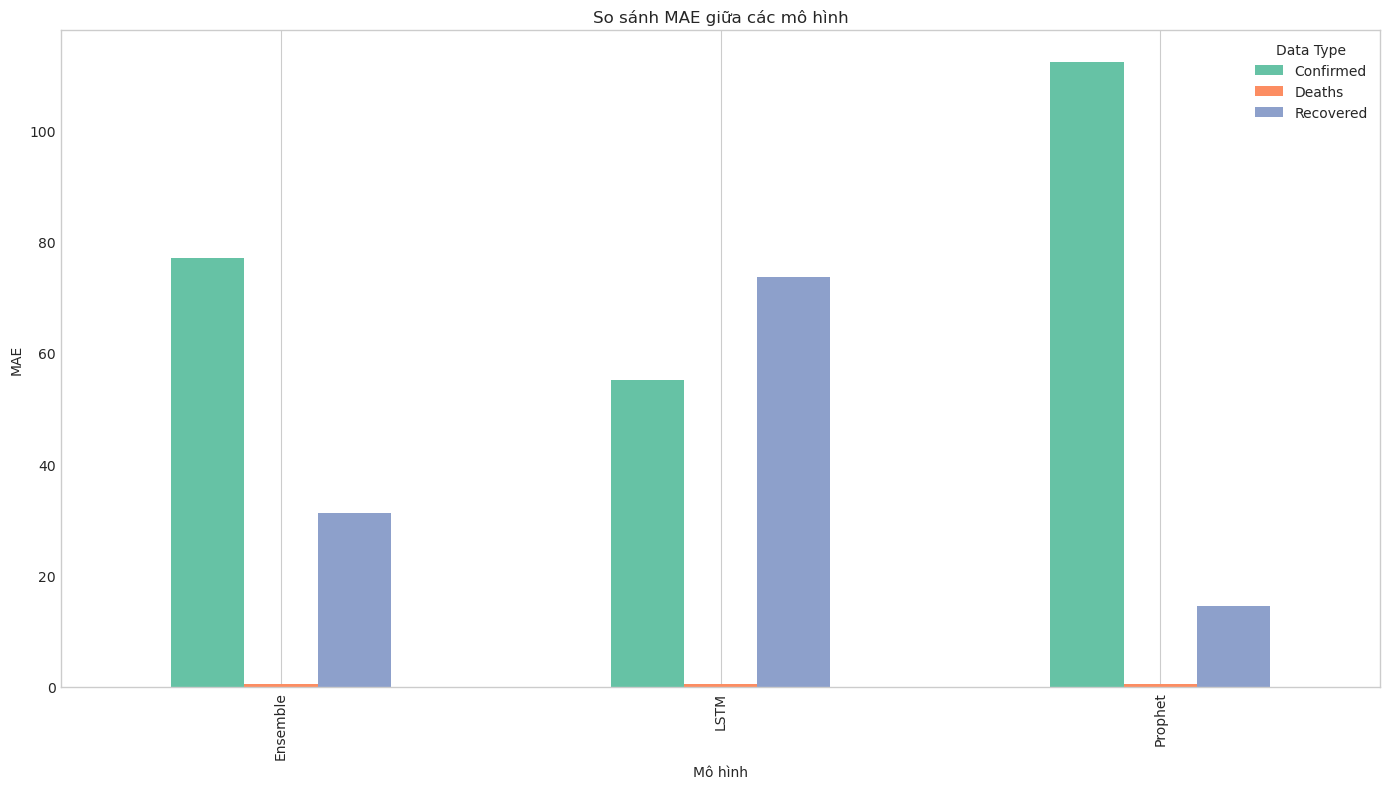

In [26]:

mae_df = metrics_df[metrics_df['Metric'] == 'MAE'].pivot(
    index='Model', columns='Data Type', values='Value'
)

plt.figure(figsize=(12, 6))
mae_df.plot(kind='bar')
plt.title('So sánh MAE giữa các mô hình')
plt.ylabel('MAE')
plt.xlabel('Mô hình')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

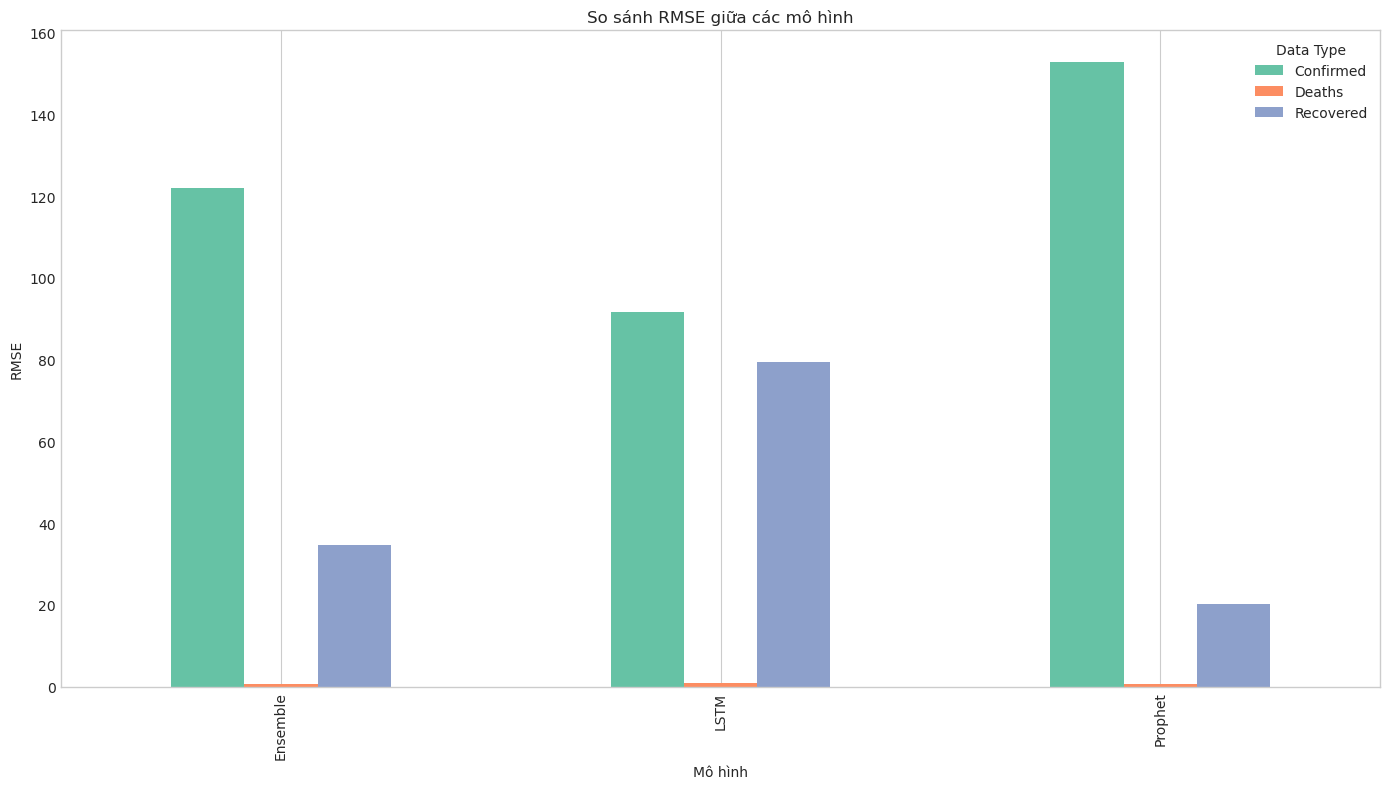

In [27]:

rmse_df = metrics_df[metrics_df['Metric'] == 'RMSE'].pivot(
    index='Model', columns='Data Type', values='Value'
)

plt.figure(figsize=(12, 6))
rmse_df.plot(kind='bar')
plt.title('So sánh RMSE giữa các mô hình')
plt.ylabel('RMSE')
plt.xlabel('Mô hình')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

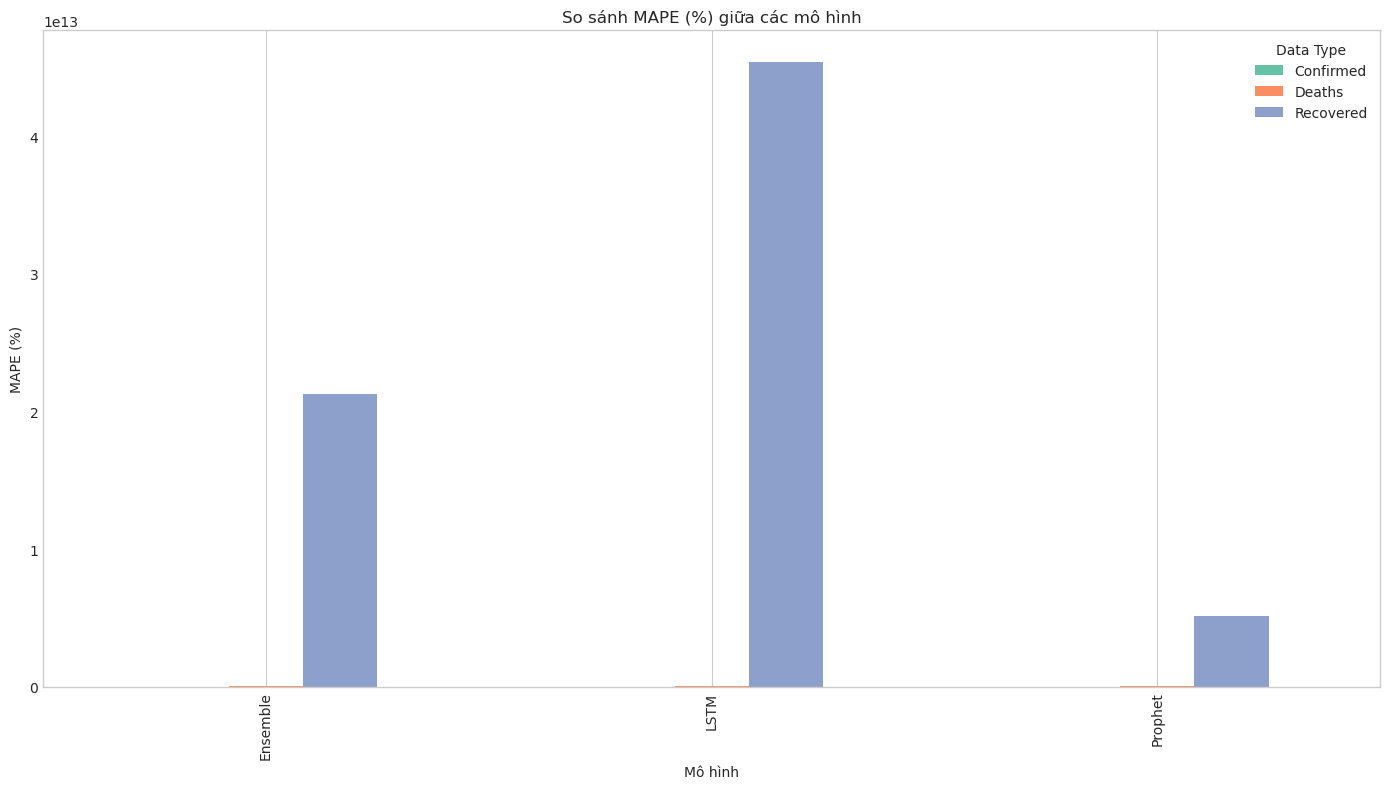

In [28]:

mape_df = metrics_df[metrics_df['Metric'] == 'MAPE'].pivot(
    index='Model', columns='Data Type', values='Value'
)

plt.figure(figsize=(12, 6))
mape_df.plot(kind='bar')
plt.title('So sánh MAPE (%) giữa các mô hình')
plt.ylabel('MAPE (%)')
plt.xlabel('Mô hình')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


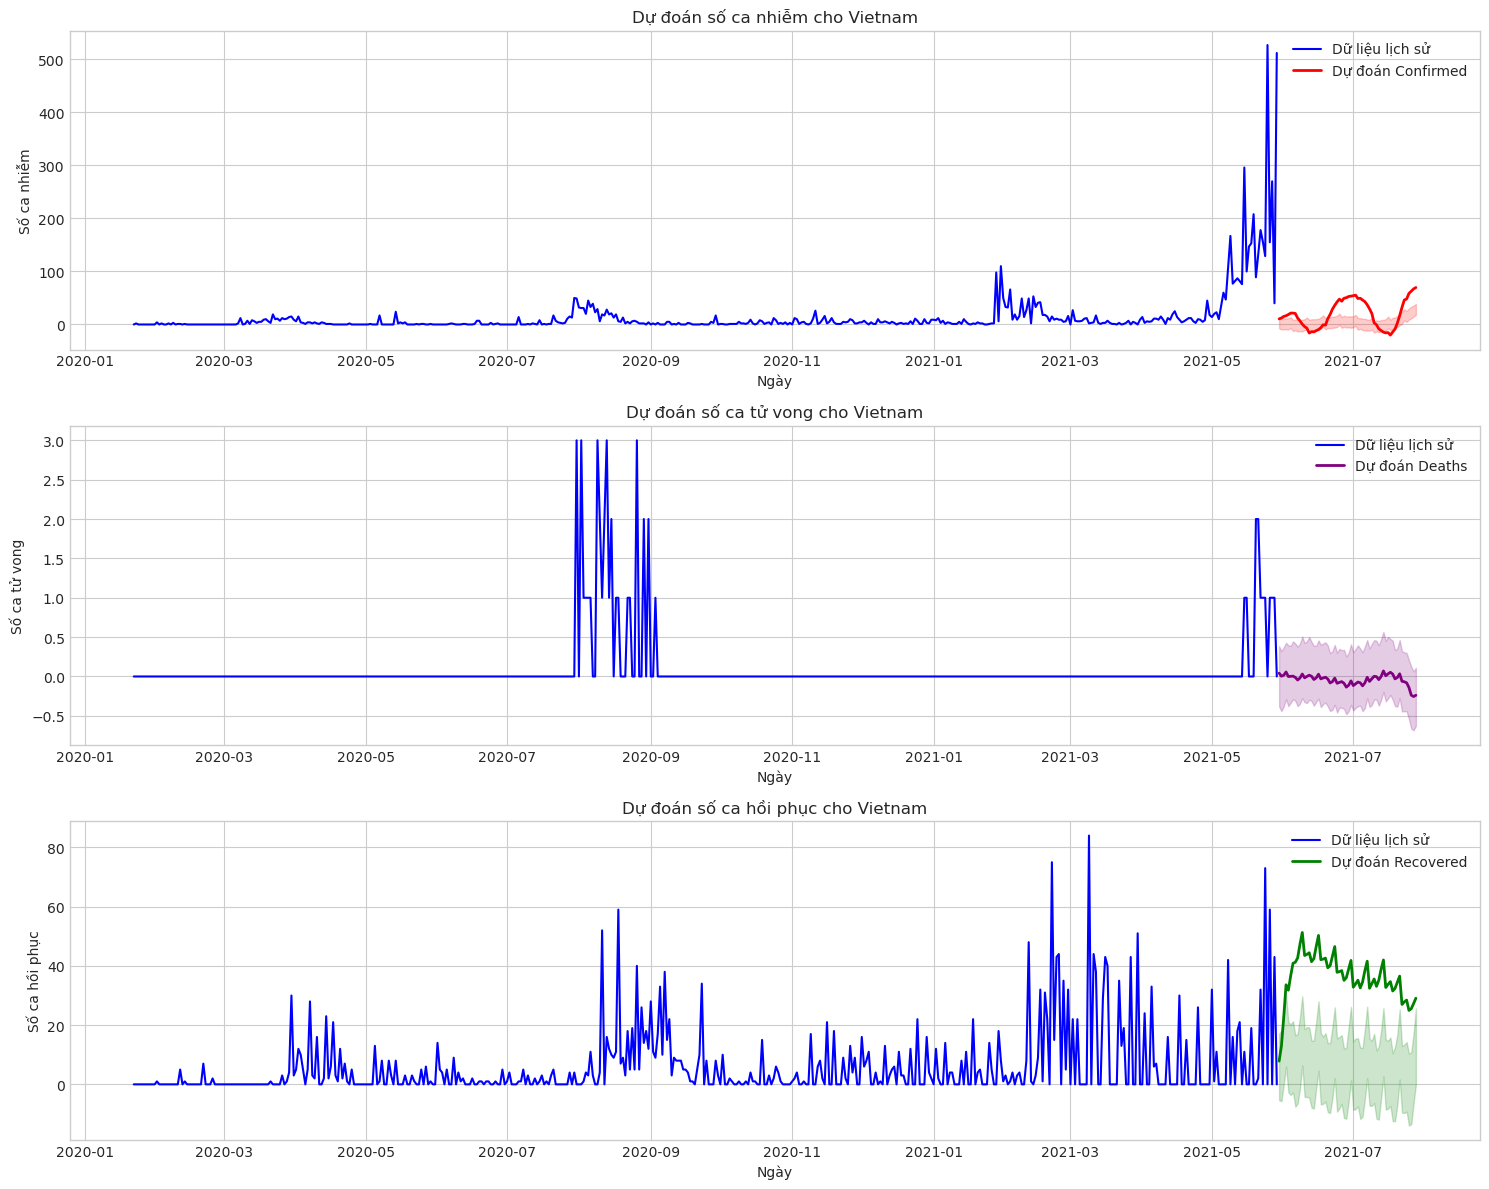


Đã hoàn thành huấn luyện và dự đoán cho tất cả loại dữ liệu COVID-19 của Vietnam!


In [29]:
plt.figure(figsize=(15, 12))

plt.subplot(3, 1, 1)
plt.plot(confirmed_data['Date'], confirmed_data["Confirmed"], label='Dữ liệu lịch sử', color='blue')
plt.plot(confirmed_future['Date'], confirmed_future['Ensemble_Prediction'], 
         label='Dự đoán Confirmed', linewidth=2, color='red')
plt.fill_between(
    confirmed_future['Date'],
    confirmed_future['Lower_CI'],
    confirmed_future['Upper_CI'],
    alpha=0.2, color='red'
)
plt.title(f'Dự đoán số ca nhiễm cho {country}')
plt.xlabel('Ngày')
plt.ylabel('Số ca nhiễm')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(deaths_data['Date'], deaths_data["Deaths"], label='Dữ liệu lịch sử', color='blue')
plt.plot(deaths_future['Date'], deaths_future['Ensemble_Prediction'], 
         label='Dự đoán Deaths', linewidth=2, color='purple')
plt.fill_between(
    deaths_future['Date'],
    deaths_future['Lower_CI'],
    deaths_future['Upper_CI'],
    alpha=0.2, color='purple'
)
plt.title(f'Dự đoán số ca tử vong cho {country}')
plt.xlabel('Ngày')
plt.ylabel('Số ca tử vong')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(recovered_data['Date'], recovered_data["Recovered"], label='Dữ liệu lịch sử', color='blue')
plt.plot(recovered_future['Date'], recovered_future['Ensemble_Prediction'], 
         label='Dự đoán Recovered', linewidth=2, color='green')
plt.fill_between(
    recovered_future['Date'],
    recovered_future['Lower_CI'],
    recovered_future['Upper_CI'],
    alpha=0.2, color='green'
)
plt.title(f'Dự đoán số ca hồi phục cho {country}')
plt.xlabel('Ngày')
plt.ylabel('Số ca hồi phục')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"\nĐã hoàn thành huấn luyện và dự đoán cho tất cả loại dữ liệu COVID-19 của {country}!")